# **Reinforcement Learning: Q-learning per trading**

#### **Obiettivo**

L'obiettivo del presente progetto è stata la creazione di un algoritmo di trading automatizzato. L'agente coinvolto nel progetto assume la responsabilità delle decisioni di acquisto e vendita di asset finanziari, facendo uso dell'algoritmo **Q-learning**.
È stato pertanto necessario condurre l'addestramento dell'agente utilizzando dati storici relativi all'asset, seguito da una fase di test delle prestazioni utilizzando dati di verifica. Il fine ultimo di questo processo di addestramento è la massimizzazione delle performance finanziarie, valutate attraverso il **Return on Investment** (ROI).

## **Librerie e Dataset**

#### Collegamento al drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Librerie

In [2]:
%pip install gym-anytrading

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.4 MB/s eta 0:00:00


In [3]:
%pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.1 MB/s eta 0:00:00


In [4]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.datasets import STOCKS_GOOGL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from __future__ import annotations
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from matplotlib.patches import Patch
import os
import dill
import pandas as pd
from sklearn.model_selection import train_test_split

#### Import del dataset

In [24]:
Stock =  pd.read_csv("/content/drive/MyDrive/Prog IA/SP500.csv")                   ## SP500 va dal 1973-02-19 al 2023-12-15
len_Stock = len(Stock)
ottanta_perc = int(len_Stock*0.70)
Stock_train = Stock.iloc[0:ottanta_perc, :]
Stock_test = Stock.iloc[ottanta_perc:len_Stock, :]


len_Stock_train = len(Stock_train)
print("Lunghezza dataset di train: ", len(Stock_train))
len_Stock_test = len(Stock_test)
print("Lunghezza dataset di test: ", len(Stock_test))

def load_dataset(name, index_name):
    df = Stock_train
    return df

STOCKS_train = load_dataset('STOCKS_train', 'Date')

def load_dataset(name, index_name):
    df = Stock_test
    return df

STOCKS_test = load_dataset('STOCKS_test', 'Date')

Lunghezza dataset di train:  1856
Lunghezza dataset di test:  796


## **Definizione dell'Agente**

L'agente che è stato implementato per svolgere il task di reinforcement learning sfrutta come algoritmo per prendere decisioni il Q-learning.
Le azioni che l'agente può svolgere sono due, buy and sell, mentre l'azione hold avviene fin quando sceglie di passare dalla posizione long alla posizione short e viceversa.
In particolare è stato necessario sviluppare una classe, chiamata TradingAgent, composta dai seguenti metodi:


*   **\_\_init__** **:** Inizializza gli iper-parametri
*   **get_action** **:** Restituisce la migliore azione
*   **update** **:** Aggiorna il q-value
*   **decay_epsilon** **:** Calcola la diminuzione dell'epsilon



In [25]:
class TradingAgent:

    """
    È stato utilizzato come base l'agente proposto da Gymnasium per il BlackJack.
    Per il codice originale si fa riferimento a:
    https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
    """

    def __init__(
        self, learning_rate: float, initial_epsilon: float, epsilon_decay: float,
        final_epsilon: float, discount_factor: float,):

        ## Crea un dizionario di grandezza pari alla lunghezza dell'env
        self.q_values = defaultdict(lambda: np.zeros(env_l.action_space.n))

        ## Inizializzazione iper-parametri
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        ## Inizializza una lista vuota per conservare il TD error
        self.training_error = []

    def get_action(self, obs: list[float, float]) -> int:

        """
        Restituisce la migliore azione con probabilità (1 - epsilon),
        altrimenti con probabilità epsilon restituisce una azione random
        per esplorare l'ambiente
        """

        if np.random.random() < self.epsilon:
            return env_l.action_space.sample()

        # con probabilità (1 - epsilon) azione greedy (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: list[float, float], action: int, reward: float,
        terminated: bool, next_obs: list[float, float],):

        """
        Aggiorna il Q-value per una azione.
        Viene calcolato il temporal difference, poi il q-value, e il temporal
        difference viene salvato nella lista per vedere l'andamento
        dell'errore negli episodi.
        """

        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):

      """
      Al termine di un episodio viene chiamato questo metodo per calcolare
      la diminuizione dell'epsilon.
      """

      self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## **Training dell'agente**

#### **Inizializzazione iper-parametri**

In una prima fase vengono settati tutti gli iper-parametri necessari:

*   **discount_factor** **:** Varia tra 0 e 1, Peso delle ricompense future
*   **learning_rate** **:** Grandezza del passo di aggiornamento
*   **start_epsilon** **:** Valore epsilon iniziale, determina il fattore di esplorazione dell'agente
*   **epsilon_decay** **:** Fattore di diminuzione dell'epsilon calcolato al termine di ogni episodio
*   **final_epsilon** **:** Valore minimo che determina la probabilità di azioni casuali
*   **n_episodes** **:** Il numero di episodi determina la qualità del training

In [135]:
## Definizione dell'ambiente
env_l = gym.make('stocks-v0', df=STOCKS_train,
                 frame_bound=(1, len_Stock_train), window_size=1)
observation = env_l.reset(seed=2023)

n_episodes = 100000

## Iper-parametri del TrainingAgent

discount_factor = 0.98
learning_rate = 0.01
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.01

agent = TradingAgent(
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    discount_factor = discount_factor
)

## Iper-parametri addestramento

commissione_ingresso = 0.001   #0.1%, su 2000 sono 2 euro
commissione_uscita = 0.0005    #0.05% su 2000 sono 1 euro

portafoglio_considerato = 100000
percentuale_da_investire = 0.02
perc_stop_loss = 0.02
budget_iniziale = percentuale_da_investire

#### **Fase di addestramento**

Arriva l'ora per l'agente di apprendere e quindi di cercare la strategia che porti ad una maggiore **ricompensa** ed ad un **ROI** più alto.
Il codice **è diviso in due sezioni**, un primo if che si verifica solo al primo passo dell'episodio, e un else che invece si verifica dal secondo passo fino al termine. La divisione con il primo episodio è necessaria per definire la old_act, questa variabile servirà nella seconda parte, ossia all'interno dell'else, per verificare quando l'agente passa da acquisto a vendita e viceversa. La transizione da acquisto a vendita e da vendita ad acquisto determina la fine della posizione **Hold**, per passare ad una posizione **Long o Short**. Al termine di queste fasi viene calcolato il Ritorno dell'investimento, ed esso viene utilizzato anche come metro per aggiungere una ricompensa/penalità.

In [ ]:
env_l = gym.wrappers.RecordEpisodeStatistics(env_l, deque_size = n_episodes)
obs_l = []
history_reward = []
reward_cum = 0
Episode_lengths = []
TOT_ROI_list = []

for episode in tqdm(range(n_episodes)):
  stop_loss = 0
  guad_prov = 0
  contatore_differenza_inizio_fine = 0
  wallet = portafoglio_considerato
  budget = wallet * percentuale_da_investire
  obs, info = env_l.reset()
  ROI = 0
  ## Tupla con (valore attuale azione, differenza con azione precedente)
  obs_l = (float(obs[0][0]), 0)      #float(obs[0][1])
  done = False
  i = 0
  flag_stop_loss = False

  while not done:

      if i == 0:
        ricompensa = 0
        wallet = wallet - budget

        stop_loss = budget*perc_stop_loss
        budget = budget - (budget*commissione_ingresso)
        n_azioni = budget/obs_l[0]
        old_action = agent.get_action(obs_l)
        action = old_action

        next_obs, reward, terminated, truncated, info = env_l.step(action)
        next_obs_l = (float(next_obs[0][0]), float(next_obs[0][1]))

        agent.update(obs_l, action, ricompensa, terminated, next_obs_l)

        contatore_differenza_inizio_fine = float(next_obs_l[1])

        if episode == n_episodes-1:
          print("\n")
          print("Il prezzo è: ", obs_l)
          if action == 0:
              azione = "Venduto"
          else:
            azione = "Acquistato"
          print("L'agente ha {} ".format(azione))
          print("Il prezzo è arrivato a: ", next_obs)
          print("Ricompensa: ", ricompensa)
          print("contatore_differenza_inizio_fine: ", contatore_differenza_inizio_fine)
          print("Attualmente il budget è arrivato a : ", budget)
          print("Wallet: ", wallet)
          print("-------------------------------")

      else:
        ricompensa = 0

        action = agent.get_action(obs_l)
        if flag_stop_loss:
          if action == 0:
            action = 1
          else:
            action = 0
          flag_stop_loss = False

        next_obs, reward, terminated, truncated, info = env_l.step(action)
        next_obs_l = (float(next_obs[0][0]), float(next_obs[0][1]))

        if old_action != action:
          contatore_differenza_inizio_fine = contatore_differenza_inizio_fine + next_obs_l[1]

          if old_action == 0:

            if contatore_differenza_inizio_fine < 0:
              ricompensa = ricompensa - contatore_differenza_inizio_fine
              guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

            if contatore_differenza_inizio_fine > 0:
              ricompensa = ricompensa - contatore_differenza_inizio_fine
              guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

            budget = budget + guad_prov

          if old_action == 1:
            if contatore_differenza_inizio_fine > 0:
              ricompensa = ricompensa + contatore_differenza_inizio_fine
              guad_prov = n_azioni*contatore_differenza_inizio_fine

            if contatore_differenza_inizio_fine < 0:
              ricompensa = ricompensa + contatore_differenza_inizio_fine
              guad_prov = n_azioni*contatore_differenza_inizio_fine

            budget = budget + guad_prov

          budget = budget - (budget*commissione_uscita)
          wallet = wallet + budget
          contatore_differenza_inizio_fine = 0
          stop_loss = budget*perc_stop_loss
          budget = wallet * percentuale_da_investire
          wallet = wallet - budget
          budget = budget - (budget*commissione_ingresso)
          n_azioni = budget/obs_l[0]


        else:
          contatore_differenza_inizio_fine = contatore_differenza_inizio_fine + next_obs_l[1]

          if action == 0:
            if contatore_differenza_inizio_fine > stop_loss:
              ricompensa = ricompensa - contatore_differenza_inizio_fine
              contatore_differenza_inizio_fine = 0
              flag_stop_loss = True

            if contatore_differenza_inizio_fine < 0:
              ricompensa = ricompensa - contatore_differenza_inizio_fine
            if contatore_differenza_inizio_fine > 0:
              ricompensa = ricompensa - contatore_differenza_inizio_fine


          if action == 1:
            if contatore_differenza_inizio_fine < -1*stop_loss:
              ricompensa = ricompensa - contatore_differenza_inizio_fine
              contatore_differenza_inizio_fine = 0
              flag_stop_loss = True

            if contatore_differenza_inizio_fine > 0:
              ricompensa = ricompensa + contatore_differenza_inizio_fine
            if contatore_differenza_inizio_fine < 0:
              ricompensa = ricompensa + contatore_differenza_inizio_fine




        if episode == n_episodes-1:
          if i < 15:
            print("Il prezzo è: ", obs_l)
            if action == 0:
                azione = "Venduto"
            else:
              azione = "Acquistato"
            print("L'agente ha {} ".format(azione))
            print("Il prezzo è arrivato a: ", next_obs)
            print("Ricompensa: ", ricompensa)
            print("contatore_differenza_inizio_fine: ", contatore_differenza_inizio_fine)
            print("numero azioni per differenza: ", guad_prov)
            print("Attualmente il budget è arrivato a : ", budget)
            print("Wallet: ", wallet)
            print("-------------------------------")


      reward_cum=reward_cum+ricompensa
      i += 1

      done = terminated or truncated
      if done and old_action == action:
        if action == 0:

          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

          budget = budget + guad_prov

        if action == 1:
          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine
            guad_prov = n_azioni*contatore_differenza_inizio_fine

          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine
            guad_prov = n_azioni*contatore_differenza_inizio_fine

          budget = budget + guad_prov

        budget = budget - (budget*commissione_uscita)
        wallet = wallet + budget

      agent.update(obs_l, action, ricompensa, terminated, next_obs_l)

      old_action = action
      obs_l = next_obs_l


  TOT_ROI_list.append((((wallet-portafoglio_considerato)/portafoglio_considerato)*100))
  history_reward.append(reward_cum)
  Episode_lengths.append(i)
  reward_cum=0
  agent.decay_epsilon()

print("Ricompensa cumulativa: ", history_reward[0])
print("Return Of Investment: ", TOT_ROI_list[-1:-150:-1])
print("Return Of Investment: ", TOT_ROI_list[-1])
print("Wallet: ", wallet)
plt.cla()
env_l.unwrapped.render_all()
plt.show()

## **Grafici**



### **Grafico dell'errore**
Questo grafico è il frutto dell'andamento del **TD-error** salvato durante ogni episodio.

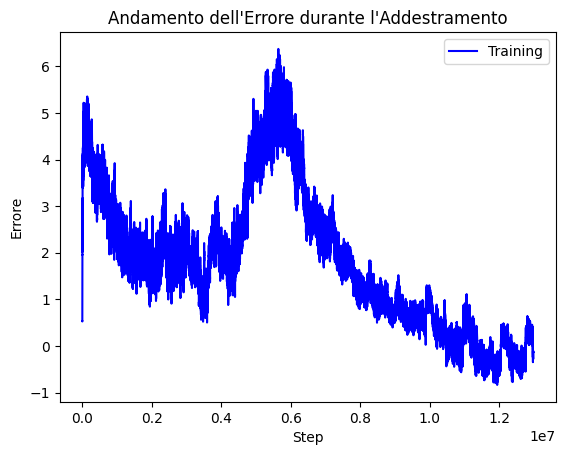

In [124]:
rolling_length = 10000
plt.plot(np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
/ rolling_length, label='Training', color='blue')
plt.title('Andamento dell\'Errore durante l\'Addestramento')
plt.xlabel('Step')
plt.ylabel('Errore')
plt.legend(loc='upper right')
plt.show()

### **Grafico andamento ricompensa**
Il grafico mostra l'andamento della ricompensa cumulativa e la ricompensa media.


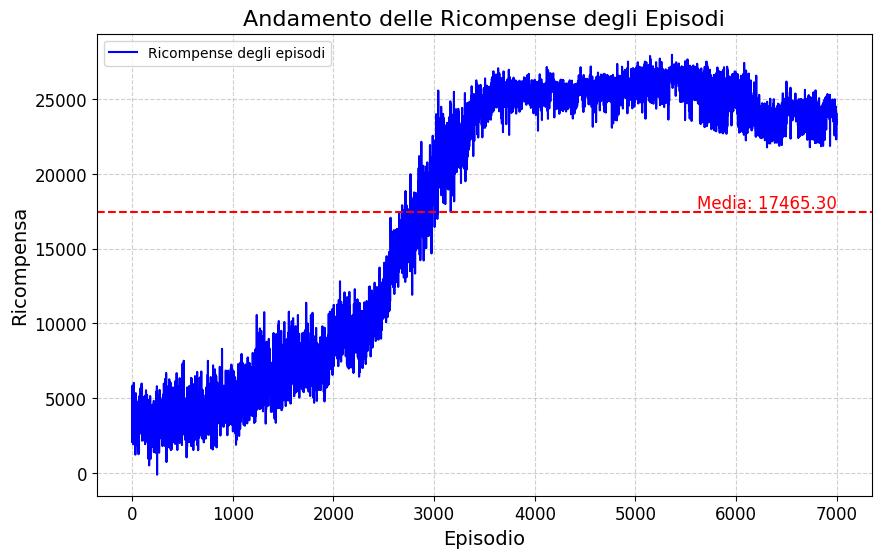

In [125]:
import matplotlib.pyplot as plt

# Lista delle ricompense degli episodi
episode_rewards = history_reward

# Plot degli episodi con una linea lineare
plt.figure(figsize=(10, 6))  # Imposta le dimensioni della figura

# Imposta lo stile della linea senza marker
plt.plot(episode_rewards, linestyle='-', color='b', label='Ricompense degli episodi')

# Aggiungi titoli e etichette agli assi
plt.title('Andamento delle Ricompense degli Episodi', fontsize=16)
plt.xlabel('Episodio', fontsize=14)
plt.ylabel('Ricompensa', fontsize=14)

# Aggiungi una griglia per facilitare la lettura del grafico
plt.grid(True, linestyle='--', alpha=0.6)

# Aggiungi una legenda
plt.legend(loc='upper left')

# Personalizza i tick degli assi
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungi una linea orizzontale per evidenziare la media delle ricompense
average_reward = sum(episode_rewards) / len(episode_rewards)
plt.axhline(y=average_reward, color='r', linestyle='--', label='Media delle Ricompense')

# Aggiungi testo per indicare la media delle ricompense
plt.text(len(episode_rewards) - 1, average_reward, f'Media: {average_reward:.2f}', ha='right', va='bottom', color='r', fontsize=12)

# Mostra il grafico
plt.show()

### **Andamento ROI**
In egual modo viene visualizzato l'andamento del ROI durante la fase di train

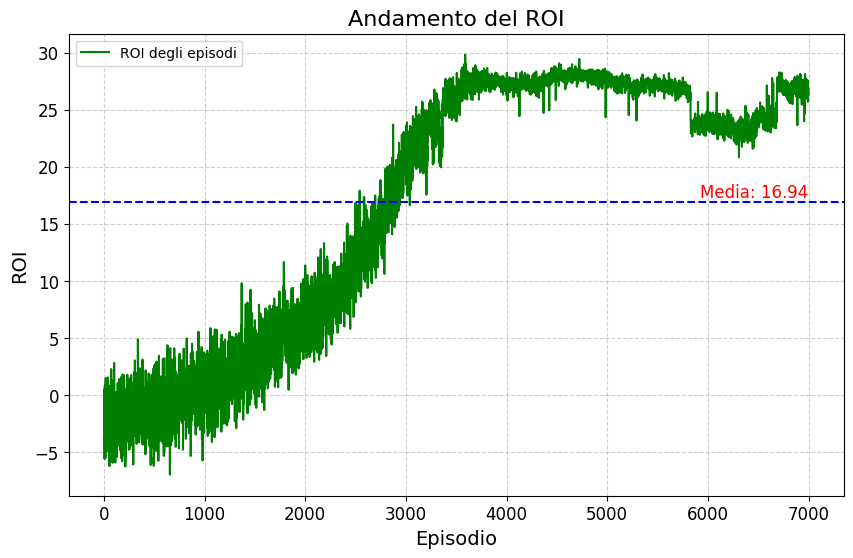

In [126]:
import matplotlib.pyplot as plt

# Lista delle ricompense degli episodi
episode_rewards = TOT_ROI_list

# Plot degli episodi con una linea lineare
plt.figure(figsize=(10, 6))  # Imposta le dimensioni della figura

# Imposta lo stile della linea senza marker
plt.plot(episode_rewards, linestyle='-', color='g', label='ROI degli episodi')

# Aggiungi titoli e etichette agli assi
plt.title('Andamento del ROI', fontsize=16)
plt.xlabel('Episodio', fontsize=14)
plt.ylabel('ROI', fontsize=14)

# Aggiungi una griglia per facilitare la lettura del grafico
plt.grid(True, linestyle='--', alpha=0.6)

# Aggiungi una legenda
plt.legend(loc='upper left')

# Personalizza i tick degli assi
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungi una linea orizzontale per evidenziare la media delle ricompense
average_reward = sum(episode_rewards) / len(episode_rewards)
plt.axhline(y=average_reward, color='b', linestyle='--', label='Media delle Ricompense')

# Aggiungi testo per indicare la media delle ricompense
plt.text(len(episode_rewards) - 1, average_reward, f'Media: {average_reward:.2f}', ha='right', va='bottom', color='r', fontsize=12)

# Mostra il grafico
plt.show()

## **Fase di test su dati sconosciuti**




Il prezzo è:  (1213.27001953125, 0)
L'agente ha Venduto 
Il prezzo è arrivato a:  [[1099.23    -114.04004]]
Ricompensa:  0
contatore_differenza_inizio_fine:  -114.0400390625
Attualmente il budget è arrivato a :  1998.0
Wallet:  98000.0
-------------------------------
Il prezzo è:  (1099.22998046875, -114.0400390625)
L'agente ha Venduto 
Il prezzo è arrivato a:  [[ 899.22    -200.01001]]
Ricompensa:  314.050048828125
contatore_differenza_inizio_fine:  -314.050048828125
numero azioni per differenza:  0
Attualmente il budget è arrivato a :  1998.0
Wallet:  98000.0
-------------------------------
Il prezzo è:  (899.219970703125, -200.010009765625)
L'agente ha Venduto 
Il prezzo è arrivato a:  [[940.55      41.330017]]
Ricompensa:  272.72003173828125
contatore_differenza_inizio_fine:  -272.72003173828125
numero azioni per differenza:  0
Attualmente il budget è arrivato a :  1998.0
Wallet:  98000.0
-------------------------------
Il prezzo è:  (940.5499877929688, 41.33001708984375)
L'agent

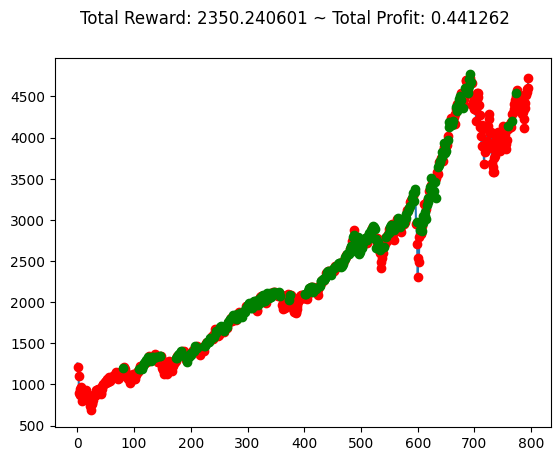

In [134]:
env_l_test = gym.make('stocks-v0', df=STOCKS_test, frame_bound=(1, len_Stock_test), window_size=1)
observation = env_l_test.reset(seed=2023)

obs_l = []

stop_loss = 0
guad_prov = 0
contatore_differenza_inizio_fine = 0
wallet = portafoglio_considerato
budget = wallet * percentuale_da_investire
obs, info = env_l_test.reset()
ROI = 0

## Tupla con (valore attuale azione, differenza con azione precedente)
obs_l = (float(obs[0][0]), 0)      #float(obs[0][1])
done = False
i = 0
flag_stop_loss = False

while not done:

    if i == 0:
      ricompensa = 0
      wallet = wallet - budget

      stop_loss = budget*perc_stop_loss
      budget = budget - (budget*commissione_ingresso)
      n_azioni = budget/obs_l[0]
      old_action = agent.get_action(obs_l)
      action = old_action

      next_obs, reward, terminated, truncated, info = env_l_test.step(action)
      next_obs_l = (float(next_obs[0][0]), float(next_obs[0][1]))

      agent.update(obs_l, action, ricompensa, terminated, next_obs_l)

      contatore_differenza_inizio_fine = float(next_obs_l[1])

      if episode == n_episodes-1:
        print("\n")
        print("Il prezzo è: ", obs_l)
        if action == 0:
            azione = "Venduto"
        else:
          azione = "Acquistato"
        print("L'agente ha {} ".format(azione))
        print("Il prezzo è arrivato a: ", next_obs)
        print("Ricompensa: ", ricompensa)
        print("contatore_differenza_inizio_fine: ", contatore_differenza_inizio_fine)
        print("Attualmente il budget è arrivato a : ", budget)
        print("Wallet: ", wallet)
        print("-------------------------------")

    else:
      ricompensa = 0

      action = agent.get_action(obs_l)

      if flag_stop_loss:
        if action == 0:
          action = 1
        else:
          action = 0
        flag_stop_loss = False

      next_obs, reward, terminated, truncated, info = env_l_test.step(action)
      next_obs_l = (float(next_obs[0][0]), float(next_obs[0][1]))

      if old_action != action:
        contatore_differenza_inizio_fine = contatore_differenza_inizio_fine + next_obs_l[1]

        if old_action == 0:

          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

          budget = budget + guad_prov

        if old_action == 1:
          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine
            guad_prov = n_azioni*contatore_differenza_inizio_fine

          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine
            guad_prov = n_azioni*contatore_differenza_inizio_fine

          budget = budget + guad_prov

        budget = budget - (budget*commissione_uscita)
        wallet = wallet + budget
        contatore_differenza_inizio_fine = 0
        stop_loss = budget*perc_stop_loss
        budget = wallet * percentuale_da_investire
        wallet = wallet - budget
        budget = budget - (budget*commissione_ingresso)
        n_azioni = budget/obs_l[0]


      else:
        contatore_differenza_inizio_fine = contatore_differenza_inizio_fine + next_obs_l[1]

        if action == 0:
          if contatore_differenza_inizio_fine > stop_loss:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            contatore_differenza_inizio_fine = 0
            flag_stop_loss = True

          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa - contatore_differenza_inizio_fine


        if action == 1:
          if contatore_differenza_inizio_fine < -1*stop_loss:
            ricompensa = ricompensa - contatore_differenza_inizio_fine
            contatore_differenza_inizio_fine = 0
            flag_stop_loss = True

          if contatore_differenza_inizio_fine > 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine
          if contatore_differenza_inizio_fine < 0:
            ricompensa = ricompensa + contatore_differenza_inizio_fine




      if episode == n_episodes-1:
        if i < 15:
          print("Il prezzo è: ", obs_l)
          if action == 0:
              azione = "Venduto"
          else:
            azione = "Acquistato"
          print("L'agente ha {} ".format(azione))
          print("Il prezzo è arrivato a: ", next_obs)
          print("Ricompensa: ", ricompensa)
          print("contatore_differenza_inizio_fine: ", contatore_differenza_inizio_fine)
          print("numero azioni per differenza: ", guad_prov)
          print("Attualmente il budget è arrivato a : ", budget)
          print("Wallet: ", wallet)
          print("-------------------------------")

    i += 1

    done = terminated or truncated
    if done and old_action == action:
      if action == 0:

        if contatore_differenza_inizio_fine < 0:
          ricompensa = ricompensa - contatore_differenza_inizio_fine
          guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

        if contatore_differenza_inizio_fine > 0:
          ricompensa = ricompensa - contatore_differenza_inizio_fine
          guad_prov = n_azioni*-1*contatore_differenza_inizio_fine

        budget = budget + guad_prov

      if action == 1:
        if contatore_differenza_inizio_fine > 0:
          ricompensa = ricompensa + contatore_differenza_inizio_fine
          guad_prov = n_azioni*contatore_differenza_inizio_fine

        if contatore_differenza_inizio_fine < 0:
          ricompensa = ricompensa + contatore_differenza_inizio_fine
          guad_prov = n_azioni*contatore_differenza_inizio_fine

        budget = budget + guad_prov

      budget = budget - (budget*commissione_uscita)
      wallet = wallet + budget

    agent.update(obs_l, action, ricompensa, terminated, next_obs_l)

    old_action = action
    obs_l = next_obs_l


ROI = (((wallet-portafoglio_considerato)/portafoglio_considerato)*100)

print("Return Of Investment: ", ROI)
print("Wallet: ", wallet)
plt.cla()
env_l_test.unwrapped.render_all()
plt.show()